In [80]:
from IPython.display import SVG
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re
import scipy
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph

In [2]:
names=['en', 'hu', 'la', 'pl', 'id', 'uro', 'pos', 'defi', 'comment']
fl = pd.read_csv('4lang', sep='\t', names=names)

# Computing the definition graph

In [3]:
fl = fl[~fl.defi.isna()]

In [4]:
fl.en = fl.en.str.lower()

In [5]:
fl.defi = fl.defi.str.lower()

In [6]:
fl['ambig'] = fl.en.duplicated(keep=False)

In [7]:
unambig_set = set(fl.loc[~fl.ambig,'en'])

In [8]:
def unambig_hwd(record):
    return f'{record.en}/{record.id}' if record.ambig else record.en

In [9]:
fl['unambig_hwd'] = fl.apply(unambig_hwd, axis=1)

In [10]:
def drop_needless_disambig(term):
    if '/' in term:
        word, number = term.split('/')
        if word in unambig_set:
            return word
    return term

In [11]:
concept_chars = '=@a-zA-Z_/0-9-'
parens_and_stuff = "[]<>,()'"

def get_def_graph_outlist(record):
    hwd = f'{record.en}/{record.id}' if record.ambig else record.en
    return hwd, [drop_needless_disambig(concept) 
                 for concept in re.findall(f'[{concept_chars}]+', str(record.defi))]

In [12]:
def_graph = nx.DiGraph(dict(fl.apply(get_def_graph_outlist, axis=1).values))

# Exploration

In [13]:
#SVG(svg_graph(nx.adjacency_matrix(def_graph)))

In [14]:
pd.Series(dict(def_graph.in_degree())).sort_values(ascending=False)

has           555
=agt          357
=pat          323
at            308
cause         308
             ... 
proclaim        0
procession      0
drip            0
proceed         0
-able           0
Length: 3185, dtype: int64

In [15]:
pd.Series(dict(def_graph.out_degree())).sort_values(ascending=False)

park         16
lens         16
golf         15
fox          14
honey        14
             ..
@hamburg      0
@hanukkah     0
@hawaii       0
@himalaya     0
=for          0
Length: 3185, dtype: int64

In [16]:
fl.shape

(2965, 11)

In [17]:
def_graph.number_of_nodes()

3185

In [18]:
def_graph.number_of_edges()

11023

# Primitives

In [19]:
%pprint
print(sorted(set(concept 
                 for concept in set(def_graph.nodes) - set(fl.unambig_hwd)  if not re.match('^[=@]', concept))))
%pprint

Pretty printing has been turned OFF
['all', 'also', 'be', 'before', 'celebrate', 'characteristic', 'enthusiastic', 'er', 'for', 'for/2782', 'from', 'has', 'identity', 'inherent', 'is_a', 'lack', 'next_to', 'not', 'other', 'palm', 'part_of', 'passionate', 'target', 'tired', 'want']
Pretty printing has been turned ON


# Strongly connected components

In [20]:
def get_components_with_size():
    for component in nx.strongly_connected_components(def_graph):
        yield ', '.join(sorted(component)), len(component)

In [21]:
components = pd.Series(dict(get_components_with_size()))

In [22]:
components.sort_values(ascending=False, inplace=True)

In [23]:
len(components)

2478

In [24]:
components[0]

623

In [25]:
print(components[components>2][1:].to_latex())

\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
april, august, december, february, january, jul... &  12 \\
friday, monday, saturday, sunday, thursday, tue... &   7 \\
bed, chair, cupboard, furniture, table             &   5 \\
cereal, flour, grain, wheat                        &   4 \\
draw/2707, pen, pencil, write                      &   4 \\
king, monarch, queen, royal                        &   4 \\
autumn, spring/2318, summer, winter                &   4 \\
buttocks, seat, sit                                &   3 \\
camera, lens, photograph                           &   3 \\
calm, disturb, upset                               &   3 \\
answer, question, reply                            &   3 \\
bake, bread, cake                                  &   3 \\
female, male, sex                                  &   3 \\
justice, right/1191, wrong                         &   3 \\
actor, stage/2220, theatre                         &   3 \\
many, much, quantity                              

/tmp/ipykernel_12502/2481590247.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(components[components>2][1:].to_latex())


In [26]:
components[components==3]

buttocks, seat, sit           3
camera, lens, photograph      3
calm, disturb, upset          3
answer, question, reply       3
bake, bread, cake             3
female, male, sex             3
justice, right/1191, wrong    3
actor, stage/2220, theatre    3
many, much, quantity          3
husband, marriage, wife       3
poem, poet, poetry            3
cutlery, fork, spoon          3
dtype: int64

In [27]:
components[components==2].to_latex

<bound method NDFrame.to_latex of president, republic       2
bell, ring/2735           2
bottle, glass             2
dirt, dust                2
hill, mountain            2
hang, swing               2
problem, solve            2
thick/2134, thin/1038     2
acid, sour                2
door, entrance            2
attention, interesting    2
elephant, trunk/1910      2
guest, host/2605          2
rat, rodent               2
soap, wash                2
now, this                 2
level, scale              2
programme, television     2
dig, spade                2
cause, reason             2
news, newspaper           2
electricity, wire         2
school, student           2
balance/1607, weigh       2
brush, paint              2
horse, ride               2
book, page                2
exist, real               2
dtype: int64>

In [28]:
components[components==1].index

Index(['linoleum', 'lime/1609', 'lip', 'lightning', 'lime/2773', 'literature',
       'light-coloured', 'kiss', 'light/944', 'kitchen',
       ...
       'beard', 'hit', 'beat', 'beautify', 'because', 'store', 'shelf', 'pity',
       'beg', 'vine'],
      dtype='object', length=2430)

## Edges between the huge component and the medium ones

In [29]:
'month' in components.index[0]

True

In [30]:
%pprint
print(sorted(list(nx.neighbors(def_graph, 'month'))))
%pprint

Pretty printing has been turned OFF
['part_of', 'time', 'twelve', 'unit', 'year']
Pretty printing has been turned ON


In [31]:
%pprint
print(sorted(list(nx.neighbors(def_graph.reverse(), 'month'))))
%pprint

Pretty printing has been turned OFF
['12-month', 'april', 'august', 'date', 'day', 'december', 'february', 'january', 'july', 'june', 'march/1563', 'may/1560', 'november', 'october', 'salary', 'september', 'year']
Pretty printing has been turned ON


## Singletons

In [32]:
in_degree_ser = pd.Series(dict(def_graph.in_degree()))

In [33]:
out_degree_ser = pd.Series(dict(def_graph.out_degree()))

In [34]:
components[components==1]

linoleum     1
lime/1609    1
lip          1
lightning    1
lime/2773    1
            ..
store        1
shelf        1
pity         1
beg          1
vine         1
Length: 2430, dtype: int64

In [35]:
list(nx.neighbors(def_graph, 'linoleum'))

['material', 'cover', 'floor', 'strong']

In [36]:
list(nx.neighbors(def_graph.reverse(), 'linoleum'))

[]

In [37]:
components['ability']

1

In [38]:
list(nx.neighbors(def_graph, 'ability'))

['can/1246']

In [39]:
list(nx.neighbors(def_graph.reverse(), 'ability'))

['modest']

In [40]:
components['modest']

1

In [41]:
list(nx.neighbors(def_graph.reverse(), 'modest'))

['humble']

# PageRank
## The whole graph

In [42]:
def get_pagerank_df():
    columns = {}
    for damping_factor in [.85, .9, .95]:
        scores = PageRank(damping_factor=damping_factor).fit_predict(nx.adjacency_matrix(def_graph))
        columns[f'pagerank_{damping_factor}'] = dict(zip(def_graph.nodes, scores))
    df = pd.DataFrame(columns)
    df['primitive'] = [w not in fl.index for w in df.index]
    return df

In [43]:
pageRank_df = get_pagerank_df()

/tmp/ipykernel_12502/3905481045.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  scores = PageRank(damping_factor=damping_factor).fit_predict(nx.adjacency_matrix(def_graph))


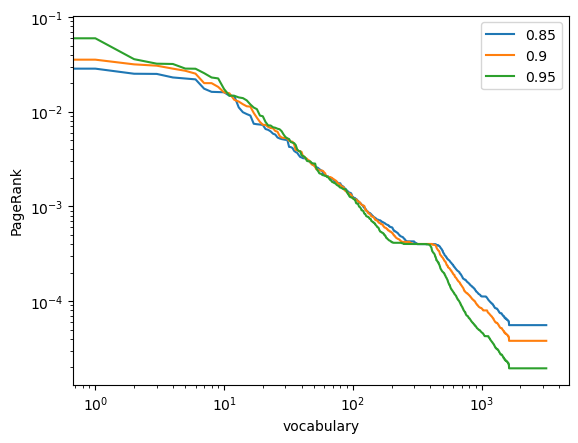

In [44]:
factors = [.85, .9, .95]
for damping_factor in factors:
    plt.plot(pageRank_df[f'pagerank_{damping_factor}'].sort_values(ascending=False).values)
plt.xscale('log')
plt.yscale('log')
plt.legend(factors)
plt.xlabel('vocabulary')
plt.ylabel('PageRank')
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-sorted-separately.png')

In [46]:
np.array([1 for _ in pageRank_df.index])

array([1, 1, 1, ..., 1, 1, 1])

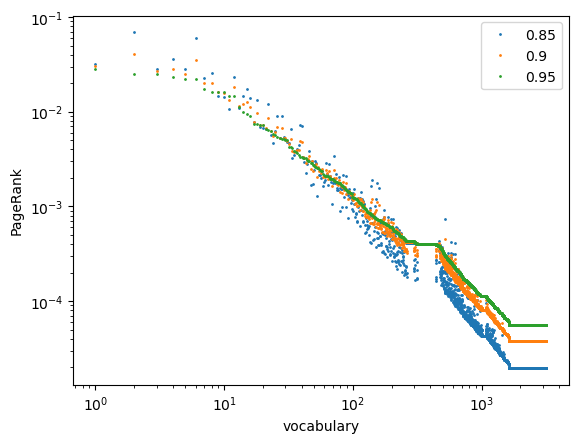

In [47]:
pageRank_df.sort_values(f'pagerank_0.85', ascending=False, inplace=True)
pageRank_df[['pagerank_0.95', 'pagerank_0.9', 'pagerank_0.85']].plot(linestyle='none', marker='.', 
                                                                     ms=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(factors)
plt.xlabel('vocabulary')
plt.ylabel('PageRank')
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-aligned.png')

/tmp/ipykernel_12502/4155689035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.sort_values(f'pagerank_0.85', ascending=False, inplace=True)


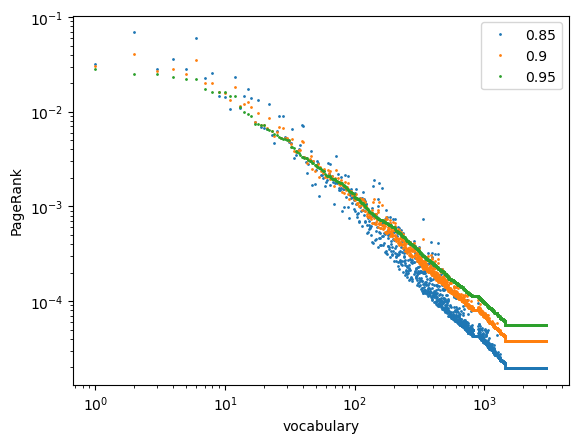

In [48]:

df_ = pageRank_df[~pageRank_df.index.str.startswith('@')]

df_.sort_values(f'pagerank_0.85', ascending=False, inplace=True)
df_[['pagerank_0.95', 'pagerank_0.9', 'pagerank_0.85']].plot(linestyle='none', marker='.', 
                                                                     ms=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(factors)
plt.xlabel('vocabulary')
plt.ylabel('PageRank')
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-aligned-noencyc.png')

## Around PageRank == 0.00004: Encyclopedic refs

In [49]:
pageRank_df.loc[(pageRank_df['pagerank_0.85']>0.000399)&(pageRank_df['pagerank_0.85']<0.000401)]#,'pagerank_0.85'].hist(bins=100)

,pagerank_0.85,pagerank_0.9,pagerank_0.95,primitive
@germany,0.0004,0.000402,0.000402,True
@finland,0.0004,0.000402,0.000402,True
@greece,0.0004,0.000402,0.000402,True
@pennsylvania,0.0004,0.000402,0.000402,True
@william_shakespeare,0.0004,0.000402,0.000402,True
...,...,...,...,...
@denmark,0.0004,0.000402,0.000402,True
@latin,0.0004,0.000402,0.000402,True
@oregon,0.0004,0.000402,0.000402,True
@liverpool,0.0004,0.000402,0.000402,True


In [50]:
pageRank_df.groupby([np.abs(pageRank_df['pagerank_0.85']-0.0004)<0.000001,pageRank_df.index.str.startswith('@')]).size()

pagerank_0.85       
False          False    2999
               True       64
True           False       1
               True      121
dtype: int64

In [51]:
pageRank_df[(np.abs(pageRank_df['pagerank_0.85']-0.0004)>=0.000001)&(pageRank_df.index.str.startswith('@'))]

,pagerank_0.85,pagerank_0.9,pagerank_0.95,primitive
@united_kingdom,0.000569,0.000527,0.000471,True
@united_states,0.000493,0.000471,0.000440,True
@karl_marx,0.000491,0.000470,0.000439,True
@arabia,0.000456,0.000443,0.000425,True
@jesus,0.000454,0.000446,0.000430,True
...,...,...,...,...
@noah,0.000386,0.000391,0.000396,True
@hindu,0.000386,0.000391,0.000396,True
@trinity,0.000383,0.000389,0.000395,True
@baseball,0.000380,0.000387,0.000394,True


In [52]:
def_graph.in_edges('@koran')

InEdgeDataView([('koran', '@koran')])

In [53]:
def_graph.in_edges('@arabia')

InEdgeDataView([('arabia', '@arabia'), ('arabian', '@arabia')])

In [54]:
def_graph.out_edges('@koran')

OutEdgeDataView([])

In [55]:
def_graph.out_edges('@arabia')

OutEdgeDataView([])

## The tail

In [71]:
pageRank_df[pageRank_df['pagerank_0.85']<.000057]

,index,pagerank_0.85,pagerank_0.9,pagerank_0.95,primitive
1634,stretch,0.000056,0.000038,0.00002,True
1635,strew,0.000056,0.000038,0.00002,True
1636,stride,0.000056,0.000038,0.00002,True
1637,base/2755,0.000056,0.000038,0.00002,True
1638,germany,0.000056,0.000038,0.00002,True
...,...,...,...,...,...
3180,crack,0.000056,0.000038,0.00002,True
3181,crazy,0.000056,0.000038,0.00002,True
3182,photography,0.000056,0.000038,0.00002,True
3183,creak,0.000056,0.000038,0.00002,True


In [57]:
def_graph.out_edges('worm')

OutEdgeDataView([('worm', 'animal'), ('worm', 'has'), ('worm', 'lack'), ('worm', 'bone'), ('worm', 'leg'), ('worm', 'soft'), ('worm', 'long')])

In [58]:
pageRank_df.reset_index(inplace=True)

In [59]:
def scatter_records(df, indic, damping_factor=.85):
    values = df.loc[indic, f'pagerank_{damping_factor}']
    plt.scatter(df[indic].index, values, s=1)

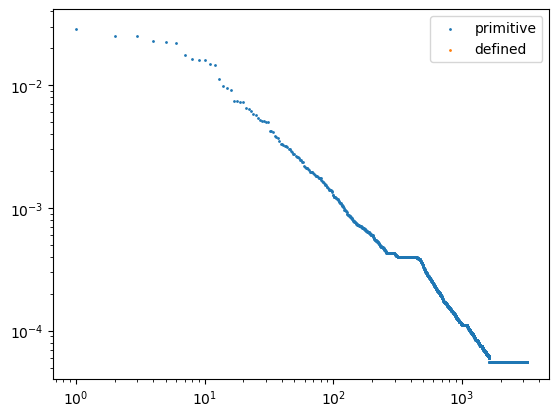

In [60]:
#factors = [.85, .9, .95]
#legend = []
damping_factor=0.85
scatter_records(pageRank_df, pageRank_df.primitive, damping_factor=damping_factor)
scatter_records(pageRank_df, ~pageRank_df.primitive, damping_factor=damping_factor)
plt.xscale('log')
plt.yscale('log')
plt.legend(['primitive', 'defined'])
plt.savefig(f'/home/makrai/repo/paper/thesis/makrai_phd/img/pageRank-85-primitive.png')

In [62]:
with open('../paper/thesis/makrai_phd/img/pageRank-of-top-concepts.tex', mode='w') as file:
    pass # file.write(pageRank_df.head(38).style.to_latex())

# The top

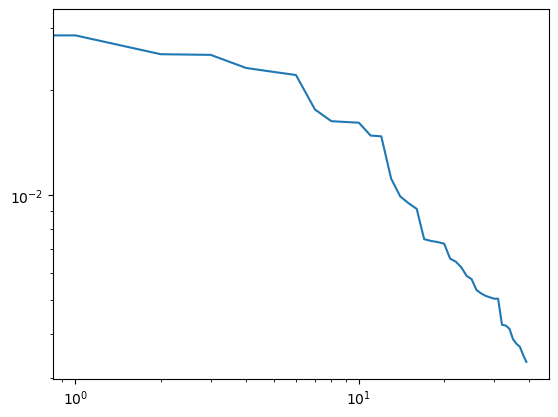

In [68]:
pageRank_df['pagerank_0.85'].iloc[:40].plot()
plt.xscale('log')
plt.yscale('log')

In [64]:
pageRank_df.head(20)

,index,pagerank_0.85,pagerank_0.9,pagerank_0.95,primitive
0,has,0.030417,0.031716,0.032239,True
1,=pat,0.028574,0.030711,0.032011,True
2,exist,0.025244,0.040721,0.069136,True
3,at,0.025138,0.027126,0.028517,True
4,reason,0.023064,0.028577,0.035985,True
5,cause,0.022473,0.025304,0.028615,True
6,real,0.022016,0.035551,0.059786,True
7,place/1026,0.017554,0.020090,0.022533,True
8,er,0.016251,0.020077,0.025601,True
9,in,0.016165,0.016037,0.014831,True


In [ ]:
fl.uro.fillna('', inplace=True)

In [ ]:
columns = ['en', 'pagerank_0.85', 'pagerank_0.9', 'pagerank_0.95', 'hu', 'la', 'pl', 'uro', 'pos', 'defi']
with open('../paper/thesis/makrai_phd/img/4lang-by-PageRank.tex', mode='w') as file:
    pass
    # file.write(fl[columns].head(30).style.to_latex())

## _Exist_ and _real_

### Out-neighbors

In [ ]:
list(def_graph.neighbors('exist'))

In [ ]:
list(def_graph.neighbors('real'))

### In-neighbors

In [ ]:
%pprint
print(sorted(list(def_graph.reverse().neighbors('exist'))))
%pprint

In [ ]:
%pprint
print(sorted(list(def_graph.reverse().neighbors('real'))))
%pprint

## Undamped PageRank of the largest component
### i.e. the principal eigenvector of the transition mx

In [103]:
def get_vertices():
    for component in nx.strongly_connected_components(def_graph):
        if len(component) > 12:
            return component

In [104]:
vertices = get_largest_comp()
largest_comp = def_graph.subgraph(vertices)

In [257]:
mx = nx.adjacency_matrix(largest_comp).toarray().astype('float')

/tmp/ipykernel_12502/2988694224.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mx = nx.adjacency_matrix(largest_comp).toarray().astype('float')


In [263]:
mx /= mx.sum(axis=0).reshape((1,-1))

In [264]:
eigenvalues, eigenvectors = np.linalg.eig(mx)

In [276]:
leading_eigvec = eigenvectors[:,np.abs(eigenvalues).argsort()[-1]]

In [277]:
page_rank_ser = pd.Series(dict(zip(vertices, leading_eigvec)))

In [278]:
page_rank_ser.sort_values(inplace=True, ascending=False)

In [285]:
page_rank_ser.head()

leaf     0.509886+0.000000j
stem     0.454530+0.000000j
plant    0.309972+0.000000j
milk     0.257400+0.000000j
cow      0.243664+0.000000j
dtype: complex128

In [286]:
page_rank_ser.tail()

full       4.842055e-07+0.000000e+00j
small      2.127782e-07+0.000000e+00j
piece      1.858871e-07+0.000000e+00j
empty      1.554902e-07+0.000000e+00j
contain    1.554902e-07+0.000000e+00j
dtype: complex128

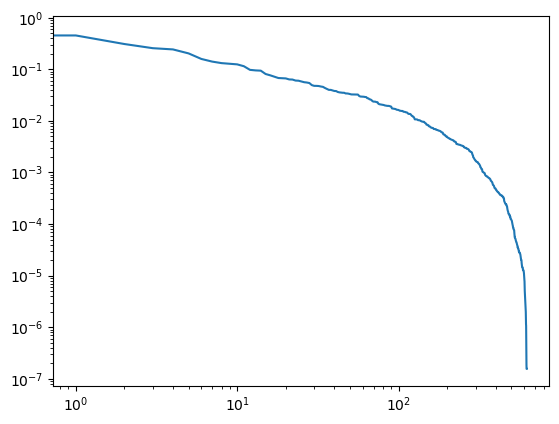

In [288]:
page_rank_ser.plot()
plt.xscale('log')
plt.yscale('log')

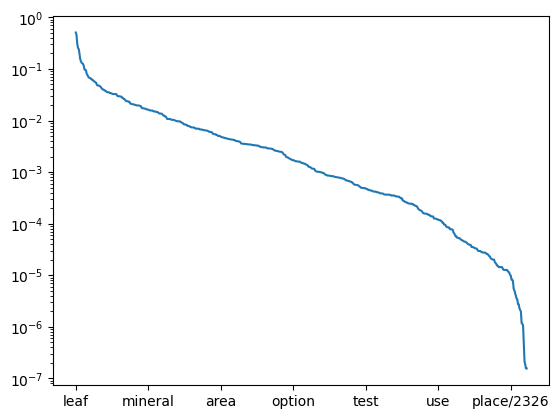

In [283]:
page_rank_ser.plot()
#plt.xscale('log')
plt.yscale('log')

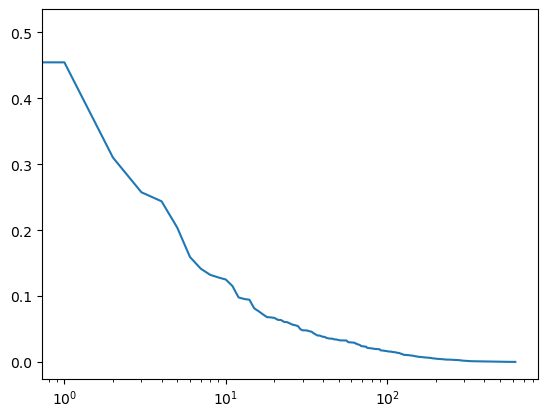

In [284]:
page_rank_ser.plot()
plt.xscale('log')
#plt.yscale('log')